## <font color = 'radium'> 5.1 >>> Problem Statement : What is the optimal Bowling stratagy in Chinnaswami, Which type of bowler to use, and When? </font>

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.expand_frame_repr',False)
pd.set_option('max_colwidth',-1)

In [2]:
ipldataset = pd.read_csv('cleaned_ipl_dataset_2008_to_2022.csv')

df = ipldataset.copy()

In [3]:
def ball_per_wickets(balls,wickets):
    if wickets == 0:
        return balls/1
    else:
        return balls/wickets
    
def runs_per_wickets(runs,wickets):
    if wickets == 0:
        return runs/1
    else:
        return runs/wickets

def Bowler_WK(player_dismissed,wicket_type):
    if type(player_dismissed)==str:
        if wicket_type not in ['run out','retired hurt', 'obstructing the field', 'retired out']:
            return 1
        else:
            return 0
    else:
        return 0

In [4]:
def BowlerCustom(df,current_phase,current_venue):

    df = df[df.phase == current_phase]
    df = df[df.venue == current_venue]
    df.reset_index(inplace = True, drop = True)
    
    df['isDot'] = df['runs_off_bat'].apply(lambda x : 1 if x == 0 else 0)
    df['isOne'] = df['runs_off_bat'].apply(lambda x : 1 if x == 1 else 0)
    df['isTwo'] = df['runs_off_bat'].apply(lambda x : 1 if x == 2 else 0)
    df['isThree'] = df['runs_off_bat'].apply(lambda x : 1 if x == 3 else 0)
    df['isFour'] = df['runs_off_bat'].apply(lambda x : 1 if x == 4 else 0)
    df['isSix'] = df['runs_off_bat'].apply(lambda x : 1 if x == 6 else 0)

    df['isBowlerWicket'] = df.apply(lambda x : Bowler_WK(x['player_dismissed'],x['wicket_type']),axis=1)

    df['runs'] = df['runs_off_bat'].astype(float)
    df['wide'] = df['wides'].fillna(0)
    df['noball'] = df['noballs'].fillna(0)

    df['isBowlerRuns'] = df['runs'] + df['wide'] + df['noball']

    innings = pd.DataFrame(df.groupby(['bowler'])['match_id'].apply(lambda x : len(list(np.unique(x))))).reset_index().rename(columns={'match_id':'innings'})
    wickets = pd.DataFrame(df.groupby(['bowler'])['isBowlerWicket'].sum()).reset_index().rename(columns={'isBowlerWicket':'wickets'})
    balls = pd.DataFrame(df.groupby(['bowler'])['legal_ball_bowler'].sum()).reset_index().rename(columns={'legal_ball_bowler':'balls'})
    runs = pd.DataFrame(df.groupby(['bowler'])['isBowlerRuns'].sum()).reset_index().rename(columns={'isBowlerRuns':'runs'})
    dots = pd.DataFrame(df.groupby(['bowler'])['isDot'].sum()).reset_index().rename(columns={'isDot':'dots'})
    fours = pd.DataFrame(df.groupby(['bowler'])['isFour'].sum()).reset_index().rename(columns={'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['bowler'])['isSix'].sum()).reset_index().rename(columns={'isSix':'sixes'})

    bowler_df = pd.merge(innings,wickets,on='bowler',how='left').merge(balls,on='bowler').merge(runs,on='bowler').merge(dots,on='bowler').merge(fours,on='bowler').merge(sixes,on='bowler')

    bowler_df['runs'] = bowler_df.runs.astype('int')
    
    bowler_df['overs'] = (bowler_df.balls/6)
    bowler_df['boundaries'] = (bowler_df.fours + bowler_df.sixes)
    bowler_df['dotp'] = 100*(bowler_df['dots']/bowler_df['balls'])
    bowler_df['eco'] = 6*(bowler_df['runs']/bowler_df['balls'])
    bowler_df['avg'] = bowler_df.apply(lambda x : runs_per_wickets(x['runs'],x['wickets']),axis=1)
    bowler_df['sr'] =  bowler_df.apply(lambda x : ball_per_wickets(x['balls'],x['wickets']),axis=1) 
    
    bowler_df = bowler_df[(bowler_df.balls >= 25) & (bowler_df.wickets > 0)]
    
    return bowler_df

In [5]:
dfp = BowlerCustom(df,'PP','M.Chinnaswamy Stadium')
dfm = BowlerCustom(df,'MO','M.Chinnaswamy Stadium')
dfd = BowlerCustom(df,'DO','M.Chinnaswamy Stadium')

# dfp.reset_index(inplace = True, drop = True)
# dfm.reset_index(inplace = True, drop = True)
# dfd.reset_index(inplace = True, drop = True)

### MINMAX SCALING

In [6]:
wt_dotp,wt_eco,wt_sr,wt_avg = 0.28,0.13,0.38,0.20

min_dotp,max_dotp = min(dfp['dotp']),max(dfp['dotp'])
min_eco,max_eco = min(dfp['eco']),max(dfp['eco'])
min_avg,max_avg = min(dfp['avg']),max(dfp['avg'])
min_sr,max_sr = min(dfp['sr']),max(dfp['sr'])

dfp['mx_dotp'] = dfp['dotp'].apply(lambda x : ((x - min_dotp)/(max_dotp - min_dotp)))
dfp['mx_eco'] = dfp['eco'].apply(lambda x : ((x - min_eco)/(max_eco - min_eco)))
dfp['mx_avg'] = dfp['avg'].apply(lambda x : ((x - min_avg)/(max_avg - min_avg)))
dfp['mx_sr'] = dfp['sr'].apply(lambda x : ((x - min_sr)/(max_sr - min_sr)))

dfp['minmax_score'] = (dfp['mx_dotp'] *wt_dotp )+(dfp['mx_eco']*wt_eco)+(dfp['mx_avg']*wt_avg)+(dfp['mx_sr']*wt_sr)

dfp.sort_values(by='minmax_score',ascending=True).head()

,bowler,innings,wickets,balls,runs,dots,fours,sixes,overs,boundaries,dotp,eco,avg,sr,mx_dotp,mx_eco,mx_avg,mx_sr,minmax_score
112,PP Chawla,4,3,42,32,22,2,0,7.0,2,52.380952,4.571429,10.666667,14.000000,0.303571,0.000000,0.028485,0.094527,0.126617
41,DL Vettori,4,2,30,35,13,5,0,5.0,5,43.333333,7.000000,17.500000,15.000000,0.100000,0.398438,0.115455,0.111940,0.145425
44,DS Kulkarni,5,7,60,59,37,11,0,10.0,11,61.666667,5.900000,8.428571,8.571429,0.512500,0.217969,0.000000,0.000000,0.171836
66,JH Kallis,12,6,96,105,48,10,3,16.0,13,50.000000,6.562500,17.500000,16.000000,0.250000,0.326660,0.115455,0.129353,0.184711
145,STR Binny,6,2,48,55,20,7,1,8.0,8,41.666667,6.875000,27.500000,24.000000,0.062500,0.377930,0.242727,0.268657,0.217266


In [7]:
wt_dotp,wt_eco,wt_sr,wt_avg = 0.37,0.37,0.07,0.19

min_dotp,max_dotp = min(dfm['dotp']),max(dfm['dotp'])
min_eco,max_eco = min(dfm['eco']),max(dfm['eco'])
min_avg,max_avg = min(dfm['avg']),max(dfm['avg'])
min_sr,max_sr = min(dfm['sr']),max(dfm['sr'])

dfm['mx_dotp'] = dfm['dotp'].apply(lambda x : ((x - min_dotp)/(max_dotp - min_dotp)))
dfm['mx_eco'] = dfm['eco'].apply(lambda x : ((x - min_eco)/(max_eco - min_eco)))
dfm['mx_avg'] = dfm['avg'].apply(lambda x : ((x - min_avg)/(max_avg - min_avg)))
dfm['mx_sr'] = dfm['sr'].apply(lambda x : ((x - min_sr)/(max_sr - min_sr)))

dfm['minmax_score'] = (dfm['mx_dotp'] *wt_dotp )+(dfm['mx_eco']*wt_eco)+(dfm['mx_avg']*wt_avg)+(dfm['mx_sr']*wt_sr)

dfm.sort_values(by='minmax_score',ascending=True).head()

,bowler,innings,wickets,balls,runs,dots,fours,sixes,overs,boundaries,dotp,eco,avg,sr,mx_dotp,mx_eco,mx_avg,mx_sr,minmax_score
139,PP Ojha,2,4,48,52,14,2,1,8.0,3,29.166667,6.500000,13.000000,12.000000,0.168919,0.127451,0.028668,0.044776,0.118238
55,DL Vettori,10,7,180,160,68,9,2,30.0,11,37.777778,5.333333,22.857143,25.714286,0.378378,0.013072,0.095158,0.181237,0.175603
13,AD Mathews,2,2,36,44,11,4,1,6.0,5,30.555556,7.333333,22.000000,18.000000,0.202703,0.209150,0.089376,0.104478,0.176681
12,AB McDonald,4,3,48,66,14,7,2,8.0,9,29.166667,8.250000,22.000000,16.000000,0.168919,0.299020,0.089376,0.084577,0.196039
159,S Badree,5,2,48,56,16,4,2,8.0,6,33.333333,7.000000,28.000000,24.000000,0.270270,0.176471,0.129848,0.164179,0.201458


In [8]:
wt_dotp,wt_eco,wt_sr,wt_avg = 0.34,0.39,0.11,0.16

min_dotp,max_dotp = min(dfd['dotp']),max(dfd['dotp'])
min_eco,max_eco = min(dfd['eco']),max(dfd['eco'])
min_avg,max_avg = min(dfd['avg']),max(dfd['avg'])
min_sr,max_sr = min(dfd['sr']),max(dfd['sr'])

dfd['mx_dotp'] = dfd['dotp'].apply(lambda x : ((x - min_dotp)/(max_dotp - min_dotp)))
dfd['mx_eco'] = dfd['eco'].apply(lambda x : ((x - min_eco)/(max_eco - min_eco)))
dfd['mx_avg'] = dfd['avg'].apply(lambda x : ((x - min_avg)/(max_avg - min_avg)))
dfd['mx_sr'] = dfd['sr'].apply(lambda x : ((x - min_sr)/(max_sr - min_sr)))

dfd['minmax_score'] = (dfd['mx_dotp'] *wt_dotp )+(dfd['mx_eco']*wt_eco)+(dfd['mx_avg']*wt_avg)+(dfd['mx_sr']*wt_sr)

dfd.sort_values(by='minmax_score',ascending=True).head()

,bowler,innings,wickets,balls,runs,dots,fours,sixes,overs,boundaries,dotp,eco,avg,sr,mx_dotp,mx_eco,mx_avg,mx_sr,minmax_score
89,MM Sharma,4,1,33,53,6,3,3,5.500000,6,18.181818,9.636364,53.000000,33.000000,0.000000,0.368984,0.352863,0.442029,0.248985
152,Z Khan,18,9,120,158,42,12,6,20.000000,18,35.000000,7.900000,17.555556,13.333333,0.528571,0.164706,0.069685,0.109501,0.267144
65,JJ Bumrah,6,4,54,60,24,3,2,9.000000,5,44.444444,6.666667,15.000000,13.500000,0.825397,0.019608,0.049268,0.112319,0.308520
122,S Aravind,8,6,43,53,19,4,2,7.166667,6,44.186047,7.395349,8.833333,7.166667,0.817276,0.105335,0.000000,0.005233,0.319530
119,RP Singh,10,11,84,120,33,11,4,14.000000,15,39.285714,8.571429,10.909091,7.636364,0.663265,0.243697,0.016584,0.013175,0.324655


### STANDARD DEVIATION SCALING

In [9]:
wt_dotp,wt_eco,wt_sr,wt_avg = 0.28,0.13,0.38,0.20

mean_dotp,std_dotp = np.mean(dfp['dotp']),np.std(dfp['dotp'])
mean_eco,std_eco = np.mean(dfp['eco']),np.std(dfp['eco'])
mean_avg,std_avg = np.mean(dfp['avg']),np.std(dfp['avg'])
mean_sr,std_sr = np.mean(dfp['sr']),np.std(dfp['sr'])

dfp['sd_dotp'] = dfp['dotp'].apply(lambda x : ((x - mean_dotp)/(std_dotp)))
dfp['sd_eco'] = dfp['eco'].apply(lambda x : ((x - mean_eco)/(std_eco)))
dfp['sd_avg'] = dfp['avg'].apply(lambda x : ((x - mean_avg)/(std_avg)))
dfp['sd_sr'] = dfp['sr'].apply(lambda x : ((x - mean_sr)/(std_sr)))

dfp['std_dev_score'] = (dfp['sd_dotp'] *wt_dotp )+(dfp['sd_eco']*wt_eco)+(dfp['sd_avg']*wt_avg)+(dfp['sd_sr']*wt_sr)

dfp.sort_values(by='std_dev_score',ascending=True).head()

,bowler,innings,wickets,balls,runs,dots,fours,sixes,overs,boundaries,dotp,eco,avg,sr,mx_dotp,mx_eco,mx_avg,mx_sr,minmax_score,sd_dotp,sd_eco,sd_avg,sd_sr,std_dev_score
112,PP Chawla,4,3,42,32,22,2,0,7.0,2,52.380952,4.571429,10.666667,14.000000,0.303571,0.000000,0.028485,0.094527,0.126617,-0.364312,-1.981092,-1.314234,-1.010241,-1.006288
41,DL Vettori,4,2,30,35,13,5,0,5.0,5,43.333333,7.000000,17.500000,15.000000,0.100000,0.398438,0.115455,0.111940,0.145425,-1.372939,-0.255710,-0.943841,-0.939303,-0.963368
66,JH Kallis,12,6,96,105,48,10,3,16.0,13,50.000000,6.562500,17.500000,16.000000,0.250000,0.326660,0.115455,0.129353,0.184711,-0.629740,-0.566533,-0.943841,-0.868364,-0.768723
44,DS Kulkarni,5,7,60,59,37,11,0,10.0,11,61.666667,5.900000,8.428571,8.571429,0.512500,0.217969,0.000000,0.000000,0.171836,0.670857,-1.037207,-1.435548,-1.395335,-0.764334
145,STR Binny,6,2,48,55,20,7,1,8.0,8,41.666667,6.875000,27.500000,24.000000,0.062500,0.377930,0.242727,0.268657,0.217266,-1.558738,-0.344516,-0.401802,-0.300857,-0.675920


In [10]:
wt_dotp,wt_eco,wt_sr,wt_avg = 0.37,0.37,0.07,0.19

mean_dotp,std_dotp = np.mean(dfm['dotp']),np.std(dfm['dotp'])
mean_eco,std_eco = np.mean(dfm['eco']),np.std(dfm['eco'])
mean_avg,std_avg = np.mean(dfm['avg']),np.std(dfm['avg'])
mean_sr,std_sr = np.mean(dfm['sr']),np.std(dfm['sr'])

dfm['sd_dotp'] = dfm['dotp'].apply(lambda x : ((x - mean_dotp)/(std_dotp)))
dfm['sd_eco'] = dfm['eco'].apply(lambda x : ((x - mean_eco)/(std_eco)))
dfm['sd_avg'] = dfm['avg'].apply(lambda x : ((x - mean_avg)/(std_avg)))
dfm['sd_sr'] = dfm['sr'].apply(lambda x : ((x - mean_sr)/(std_sr)))

dfm['std_dev_score'] = (dfm['sd_dotp'] *wt_dotp )+(dfm['sd_eco']*wt_eco)+(dfm['sd_avg']*wt_avg)+(dfm['sd_sr']*wt_sr)

dfm.sort_values(by='std_dev_score',ascending=True).head()

,bowler,innings,wickets,balls,runs,dots,fours,sixes,overs,boundaries,dotp,eco,avg,sr,mx_dotp,mx_eco,mx_avg,mx_sr,minmax_score,sd_dotp,sd_eco,sd_avg,sd_sr,std_dev_score
139,PP Ojha,2,4,48,52,14,2,1,8.0,3,29.166667,6.500000,13.000000,12.000000,0.168919,0.127451,0.028668,0.044776,0.118238,-0.935174,-1.060956,-1.080087,-0.997228,-1.013591
55,DL Vettori,10,7,180,160,68,9,2,30.0,11,37.777778,5.333333,22.857143,25.714286,0.378378,0.013072,0.095158,0.181237,0.175603,0.113320,-1.699186,-0.698117,-0.175916,-0.731727
13,AD Mathews,2,2,36,44,11,4,1,6.0,5,30.555556,7.333333,22.000000,18.000000,0.202703,0.209150,0.089376,0.104478,0.176681,-0.766063,-0.605079,-0.731332,-0.637904,-0.690929
94,KV Sharma,4,7,84,89,33,4,4,14.0,8,39.285714,6.357143,12.714286,12.000000,0.415058,0.113445,0.026741,0.044776,0.203761,0.296927,-1.139107,-1.091159,-0.997228,-0.588733
12,AB McDonald,4,3,48,66,14,7,2,8.0,9,29.166667,8.250000,22.000000,16.000000,0.168919,0.299020,0.089376,0.084577,0.196039,-0.935174,-0.103613,-0.731332,-0.757679,-0.576342


In [11]:
wt_dotp,wt_eco,wt_sr,wt_avg = 0.34,0.39,0.11,0.16

mean_dotp,std_dotp = np.mean(dfd['dotp']),np.std(dfd['dotp'])
mean_eco,std_eco = np.mean(dfd['eco']),np.std(dfd['eco'])
mean_avg,std_avg = np.mean(dfd['avg']),np.std(dfd['avg'])
mean_sr,std_sr = np.mean(dfd['sr']),np.std(dfd['sr'])

dfd['sd_dotp'] = dfd['dotp'].apply(lambda x : ((x - mean_dotp)/(std_dotp)))
dfd['sd_eco'] = dfd['eco'].apply(lambda x : ((x - mean_eco)/(std_eco)))
dfd['sd_avg'] = dfd['avg'].apply(lambda x : ((x - mean_avg)/(std_avg)))
dfd['sd_sr'] = dfd['sr'].apply(lambda x : ((x - mean_sr)/(std_sr)))

dfd['std_dev_score'] = (dfd['sd_dotp'] *wt_dotp )+(dfd['sd_eco']*wt_eco)+(dfd['sd_avg']*wt_avg)+(dfd['sd_sr']*wt_sr)

dfd.sort_values(by='std_dev_score',ascending=True).head()

,bowler,innings,wickets,balls,runs,dots,fours,sixes,overs,boundaries,dotp,eco,avg,sr,mx_dotp,mx_eco,mx_avg,mx_sr,minmax_score,sd_dotp,sd_eco,sd_avg,sd_sr,std_dev_score
89,MM Sharma,4,1,33,53,6,3,3,5.500000,6,18.181818,9.636364,53.000000,33.000000,0.000000,0.368984,0.352863,0.442029,0.248985,-2.082277,-0.417706,0.601543,0.996088,-0.665063
152,Z Khan,18,9,120,158,42,12,6,20.000000,18,35.000000,7.900000,17.555556,13.333333,0.528571,0.164706,0.069685,0.109501,0.267144,-0.130728,-1.215872,-0.539974,-0.357577,-0.644367
65,JJ Bumrah,6,4,54,60,24,3,2,9.000000,5,44.444444,6.666667,15.000000,13.500000,0.825397,0.019608,0.049268,0.112319,0.308520,0.965187,-1.782808,-0.622278,-0.346106,-0.504767
122,S Aravind,8,6,43,53,19,4,2,7.166667,6,44.186047,7.395349,8.833333,7.166667,0.817276,0.105335,0.000000,0.005233,0.319530,0.935203,-1.447849,-0.820880,-0.782032,-0.464056
119,RP Singh,10,11,84,120,33,11,4,14.000000,15,39.285714,8.571429,10.909091,7.636364,0.663265,0.243697,0.016584,0.013175,0.324655,0.366578,-0.907232,-0.754029,-0.749702,-0.432296


### TOPSIS METHOD

In [12]:
wt_dotp,wt_eco,wt_sr,wt_avg = 0.28,0.13,0.38,0.20

dfp['calc_dotp'] = dfp['dotp'].apply(lambda x : x*x)
dfp['calc_avg'] = dfp['avg'].apply(lambda x : x*x)
dfp['calc_eco'] = dfp['eco'].apply(lambda x : x*x)
dfp['calc_sr'] = dfp['sr'].apply(lambda x : x*x)

sq_dot,sq_avg,sq_eco,sq_sr = np.sqrt(dfp[['calc_dotp','calc_avg','calc_eco','calc_sr']]).sum(axis=0)

dfp['calc_dotp'] = dfp['calc_dotp'].apply(lambda x : x/sq_dot)
dfp['calc_avg'] = dfp['calc_avg'].apply(lambda x : x/sq_avg)
dfp['calc_eco'] = dfp['calc_eco'].apply(lambda x : x/sq_eco)
dfp['calc_sr'] = dfp['calc_sr'].apply(lambda x : x/sq_sr)

dfp['calc_dotp'] = dfp['calc_dotp'].apply(lambda x : x*wt_dotp)
dfp['calc_avg'] = dfp['calc_avg'].apply(lambda x : x*wt_avg)
dfp['calc_eco'] = dfp['calc_eco'].apply(lambda x : x*wt_eco)
dfp['calc_sr'] = dfp['calc_sr'].apply(lambda x : x*wt_sr)

best_dotp,worst_dotp = max(dfp['calc_dotp']),min(dfp['calc_dotp'])
best_avg,worst_avg = min(dfp['calc_avg']),max(dfp['calc_avg'])
best_eco,worst_eco = min(dfp['calc_eco']),max(dfp['calc_eco'])
best_sr,worst_sr = min(dfp['calc_sr']),max(dfp['calc_sr'])

dfp['b_dotp'] = dfp['calc_dotp'].apply(lambda x : (x-best_dotp)*(x-best_dotp))
dfp['b_avg'] = dfp['calc_avg'].apply(lambda x : (x-best_avg)*(x-best_avg))
dfp['b_eco'] = dfp['calc_eco'].apply(lambda x : (x-best_eco)*(x-best_eco))
dfp['b_sr'] = dfp['calc_sr'].apply(lambda x : (x-best_sr)*(x-best_sr))

dfp['best_score'] = dfp.apply(lambda x : x['b_dotp']+x['b_avg']+x['b_eco']+x['b_sr'],axis=1)

dfp['w_dotp'] = dfp['calc_dotp'].apply(lambda x : (x-worst_dotp)*(x-worst_dotp))
dfp['w_avg'] = dfp['calc_avg'].apply(lambda x : (x-worst_avg)*(x-worst_avg))
dfp['w_eco'] = dfp['calc_eco'].apply(lambda x : (x-worst_eco)*(x-worst_eco))
dfp['w_sr'] = dfp['calc_sr'].apply(lambda x : (x-worst_sr)*(x-worst_sr))

dfp['worst_score'] = dfp.apply(lambda x : x['w_dotp']+x['w_avg']+x['w_eco']+x['w_sr'],axis=1)

dfp['T_score'] =  dfp.apply(lambda x : x['worst_score']/(x['worst_score']+x['best_score']),axis=1)

dfp.sort_values(by='T_score',ascending=False).head()
dfp.reset_index(inplace=True,drop=True)

In [13]:
wt_dotp,wt_eco,wt_sr,wt_avg = 0.37,0.37,0.07,0.19

dfm['calc_dotp'] = dfm['dotp'].apply(lambda x : x*x)
dfm['calc_avg'] = dfm['avg'].apply(lambda x : x*x)
dfm['calc_eco'] = dfm['eco'].apply(lambda x : x*x)
dfm['calc_sr'] = dfm['sr'].apply(lambda x : x*x)

sq_dot,sq_avg,sq_eco,sq_sr = np.sqrt(dfm[['calc_dotp','calc_avg','calc_eco','calc_sr']]).sum(axis=0)

dfm['calc_dotp'] = dfm['calc_dotp'].apply(lambda x : x/sq_dot)
dfm['calc_avg'] = dfm['calc_avg'].apply(lambda x : x/sq_avg)
dfm['calc_eco'] = dfm['calc_eco'].apply(lambda x : x/sq_eco)
dfm['calc_sr'] = dfm['calc_sr'].apply(lambda x : x/sq_sr)

dfm['calc_dotp'] = dfm['calc_dotp'].apply(lambda x : x*wt_dotp)
dfm['calc_avg'] = dfm['calc_avg'].apply(lambda x : x*wt_avg)
dfm['calc_eco'] = dfm['calc_eco'].apply(lambda x : x*wt_eco)
dfm['calc_sr'] = dfm['calc_sr'].apply(lambda x : x*wt_sr)

best_dotp,worst_dotp = max(dfm['calc_dotp']),min(dfm['calc_dotp'])
best_avg,worst_avg = min(dfm['calc_avg']),max(dfm['calc_avg'])
best_eco,worst_eco = min(dfm['calc_eco']),max(dfm['calc_eco'])
best_sr,worst_sr = min(dfm['calc_sr']),max(dfm['calc_sr'])

dfm['b_dotp'] = dfm['calc_dotp'].apply(lambda x : (x-best_dotp)*(x-best_dotp))
dfm['b_avg'] = dfm['calc_avg'].apply(lambda x : (x-best_avg)*(x-best_avg))
dfm['b_eco'] = dfm['calc_eco'].apply(lambda x : (x-best_eco)*(x-best_eco))
dfm['b_sr'] = dfm['calc_sr'].apply(lambda x : (x-best_sr)*(x-best_sr))

dfm['best_score'] = dfm.apply(lambda x : x['b_dotp']+x['b_avg']+x['b_eco']+x['b_sr'],axis=1)

dfm['w_dotp'] = dfm['calc_dotp'].apply(lambda x : (x-worst_dotp)*(x-worst_dotp))
dfm['w_avg'] = dfm['calc_avg'].apply(lambda x : (x-worst_avg)*(x-worst_avg))
dfm['w_eco'] = dfm['calc_eco'].apply(lambda x : (x-worst_eco)*(x-worst_eco))
dfm['w_sr'] = dfm['calc_sr'].apply(lambda x : (x-worst_sr)*(x-worst_sr))

dfm['worst_score'] = dfm.apply(lambda x : x['w_dotp']+x['w_avg']+x['w_eco']+x['w_sr'],axis=1)

dfm['T_score'] = dfm.apply(lambda x : x['worst_score']/(x['worst_score']+x['best_score']),axis=1)

dfm.sort_values(by='T_score',ascending=False).head()
dfm.reset_index(inplace=True,drop=True)

In [14]:
wt_dotp,wt_eco,wt_sr,wt_avg = 0.34,0.39,0.11,0.16

dfd['calc_dotp'] = dfd['dotp'].apply(lambda x : x*x)
dfd['calc_avg'] = dfd['avg'].apply(lambda x : x*x)
dfd['calc_eco'] = dfd['eco'].apply(lambda x : x*x)
dfd['calc_sr'] = dfd['sr'].apply(lambda x : x*x)

sq_dot,sq_avg,sq_eco,sq_sr = np.sqrt(dfd[['calc_dotp','calc_avg','calc_eco','calc_sr']]).sum(axis=0)

dfd['calc_dotp'] = dfd['calc_dotp'].apply(lambda x : x/sq_dot)
dfd['calc_avg'] = dfd['calc_avg'].apply(lambda x : x/sq_avg)
dfd['calc_eco'] = dfd['calc_eco'].apply(lambda x : x/sq_eco)
dfd['calc_sr'] = dfd['calc_sr'].apply(lambda x : x/sq_sr)

dfd['calc_dotp'] = dfd['calc_dotp'].apply(lambda x : x*wt_dotp)
dfd['calc_avg'] = dfd['calc_avg'].apply(lambda x : x*wt_avg)
dfd['calc_eco'] = dfd['calc_eco'].apply(lambda x : x*wt_eco)
dfd['calc_sr'] = dfd['calc_sr'].apply(lambda x : x*wt_sr)

best_dotp,worst_dotp = max(dfd['calc_dotp']),min(dfd['calc_dotp'])
best_avg,worst_avg = min(dfd['calc_avg']),max(dfd['calc_avg'])
best_eco,worst_eco = min(dfd['calc_eco']),max(dfd['calc_eco'])
best_sr,worst_sr = min(dfd['calc_sr']),max(dfd['calc_sr'])

dfd['b_dotp'] = dfd['calc_dotp'].apply(lambda x : (x-best_dotp)*(x-best_dotp))
dfd['b_avg'] = dfd['calc_avg'].apply(lambda x : (x-best_avg)*(x-best_avg))
dfd['b_eco'] = dfd['calc_eco'].apply(lambda x : (x-best_eco)*(x-best_eco))
dfd['b_sr'] = dfd['calc_sr'].apply(lambda x : (x-best_sr)*(x-best_sr))

dfd['best_score'] = dfd.apply(lambda x : x['b_dotp']+x['b_avg']+x['b_eco']+x['b_sr'],axis=1)

dfd['w_dotp'] = dfd['calc_dotp'].apply(lambda x : (x-worst_dotp)*(x-worst_dotp))
dfd['w_avg'] = dfd['calc_avg'].apply(lambda x : (x-worst_avg)*(x-worst_avg))
dfd['w_eco'] = dfd['calc_eco'].apply(lambda x : (x-worst_eco)*(x-worst_eco))
dfd['w_sr'] = dfd['calc_sr'].apply(lambda x : (x-worst_sr)*(x-worst_sr))

dfd['worst_score'] = dfd.apply(lambda x : x['w_dotp']+x['w_avg']+x['w_eco']+x['w_sr'],axis=1)

dfd['T_score'] = dfd.apply(lambda x : x['worst_score']/(x['worst_score']+x['best_score']),axis=1)

dfd.sort_values(by='T_score',ascending=False).head(1)
dfd.reset_index(inplace=True,drop=True)

<AxesSubplot: >

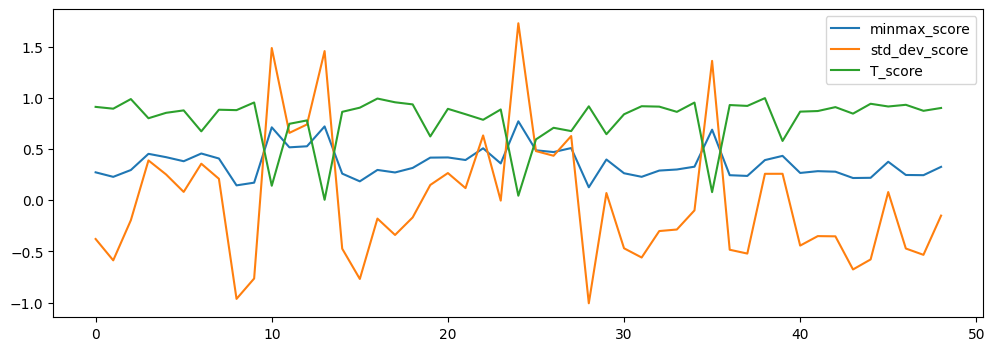

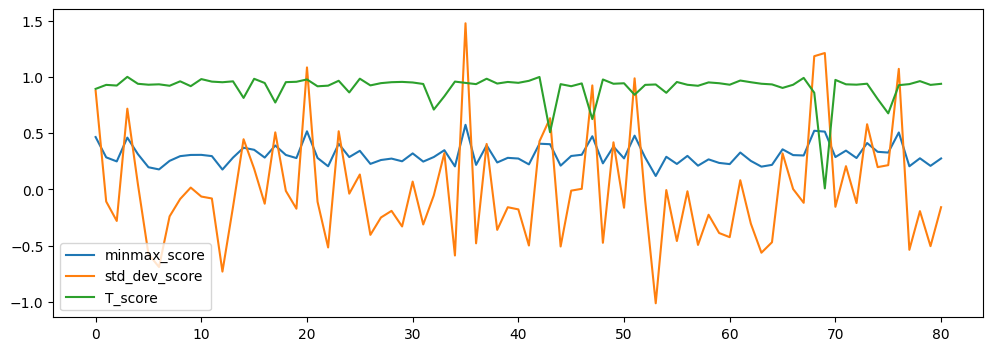

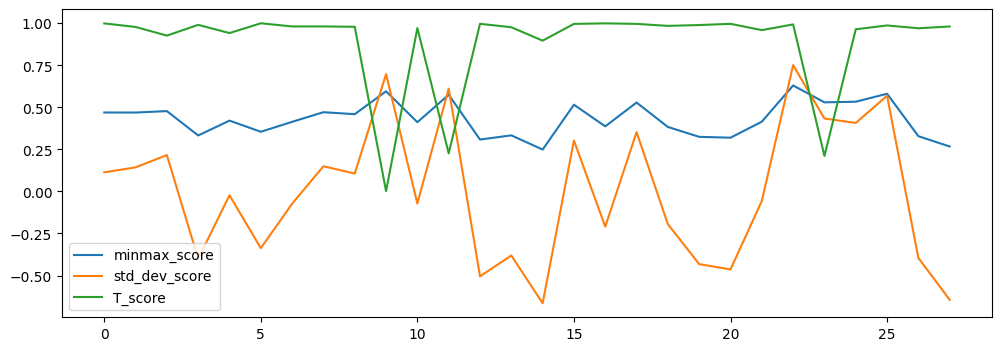

In [15]:
dfp[['minmax_score','std_dev_score','T_score']].plot(kind='line',figsize=(12,4))

dfm[['minmax_score','std_dev_score','T_score']].plot(kind='line',figsize=(12,4))

dfd[['minmax_score','std_dev_score','T_score']].plot(kind='line',figsize=(12,4))

### minmax scaling and standard deviation scaling gives relatively same values but we have to take ascending approach as minimum score gives true results.
### whereas Topsis method gives opposite score compare to minmax, and standard deviation score, that's why we have to take descending approach as maximum score gives true results. 

In [16]:
dfpm = dfp.sort_values(by='minmax_score',ascending=True).head(15)
dfpm.reset_index(inplace=True,drop=True)
dfmm = dfm.sort_values(by='minmax_score',ascending=True).head(15)
dfmm.reset_index(inplace=True,drop=True)
dfdm = dfd.sort_values(by='minmax_score',ascending=True).head(15)
dfdm.reset_index(inplace=True,drop=True)
dfps = dfp.sort_values(by='std_dev_score',ascending=True).head(15)
dfps.reset_index(inplace=True,drop=True)
dfms = dfm.sort_values(by='std_dev_score',ascending=True).head(15)
dfms.reset_index(inplace=True,drop=True)
dfds = dfd.sort_values(by='std_dev_score',ascending=True).head(15)
dfds.reset_index(inplace=True,drop=True)
dfpt = dfp.sort_values(by='T_score',ascending=False).head(15)
dfpt.reset_index(inplace=True,drop=True)
dfmt = dfm.sort_values(by='T_score',ascending=False).head(15)
dfmt.reset_index(inplace=True,drop=True)
dfdt = dfd.sort_values(by='T_score',ascending=False).head(15)
dfdt.reset_index(inplace=True,drop=True)

### POWERPLAY VISUALIZATION

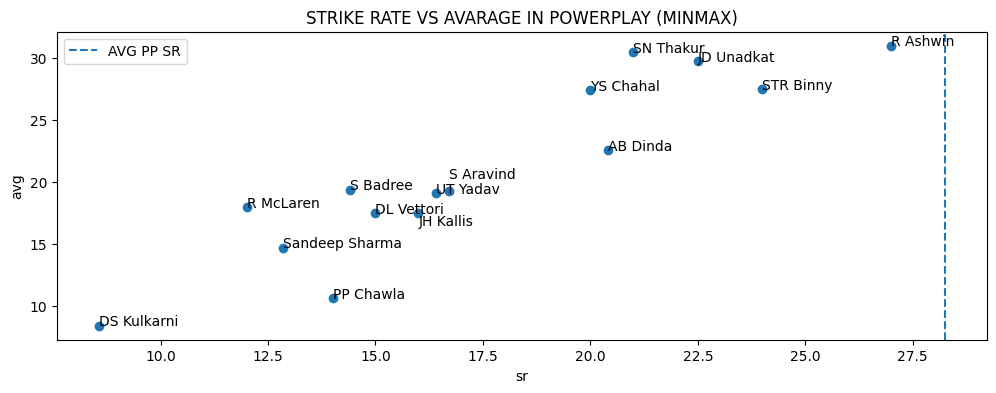

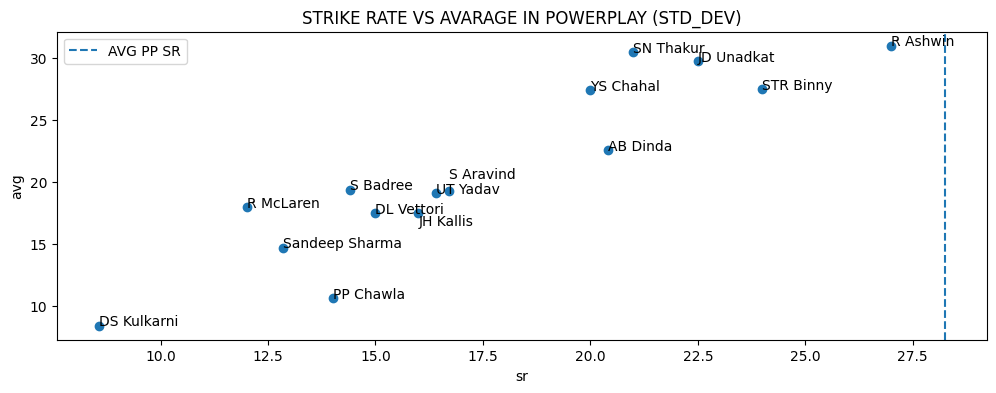

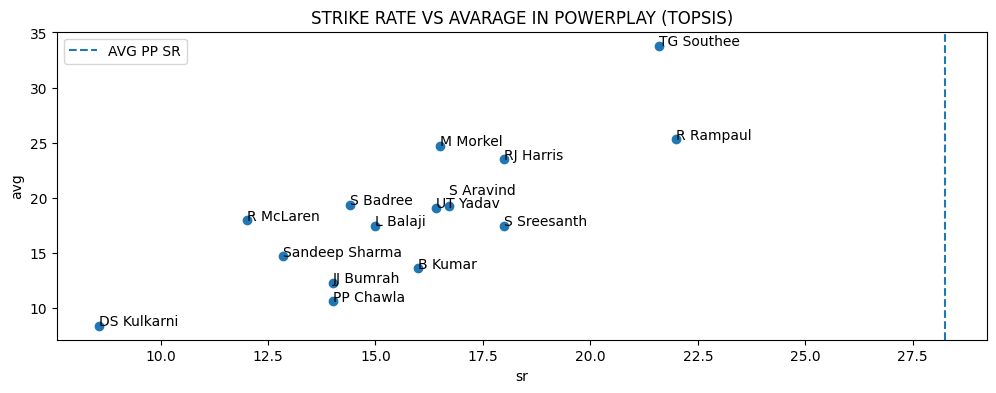

In [25]:
plt.figure(figsize=(12,4))
plt.scatter(dfpm.sr,dfpm.avg)
for i in range(len(dfpm)):
    if dfpm.bowler[i] == 'S Aravind':
        plt.text(dfpm['sr'][i],dfpm['avg'][i]+1,dfpm['bowler'][i])
    elif dfpm.bowler[i] == 'JH Kallis':
        plt.text(dfpm['sr'][i],dfpm['avg'][i]-1,dfpm['bowler'][i])
    else:
        plt.text(dfpm['sr'][i],dfpm['avg'][i],dfpm['bowler'][i])
plt.xlabel('sr')
plt.ylabel('avg')
plt.title('STRIKE RATE VS AVARAGE IN POWERPLAY (MINMAX)')
plt.axvline(np.mean(dfp.sr),ls='--',label='AVG PP SR')
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.scatter(dfps.sr,dfps.avg)
for i in range(len(dfps)):
    if dfps.bowler[i] == 'S Aravind':
        plt.text(dfps['sr'][i],dfps['avg'][i]+1,dfps['bowler'][i])
    elif dfps.bowler[i] == 'JH Kallis':
        plt.text(dfps['sr'][i],dfps['avg'][i]-1,dfps['bowler'][i])
    else:
        plt.text(dfps['sr'][i],dfps['avg'][i],dfps['bowler'][i])
plt.xlabel('sr')
plt.ylabel('avg')
plt.title('STRIKE RATE VS AVARAGE IN POWERPLAY (STD_DEV)')
plt.axvline(np.mean(dfp.sr),ls='--',label='AVG PP SR')
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.scatter(dfpt.sr,dfpt.avg)
for i in range(len(dfpt)):
    if dfpt.bowler[i] == 'S Aravind':
        plt.text(dfpt['sr'][i],dfpt['avg'][i]+1,dfpt['bowler'][i])
    elif dfpt.bowler[i] == 'DL Vettori':
        plt.text(dfpt['sr'][i],dfpt['avg'][i]+1,dfpt['bowler'][i])
    elif dfpt.bowler[i] == 'JH Kallis':
        plt.text(dfpt['sr'][i],dfpt['avg'][i]-1,dfpt['bowler'][i])
    else:
        plt.text(dfpt['sr'][i],dfpt['avg'][i],dfpt['bowler'][i])
plt.xlabel('sr')
plt.ylabel('avg')
plt.title('STRIKE RATE VS AVARAGE IN POWERPLAY (TOPSIS)')
plt.axvline(np.mean(dfp.sr),ls='--',label='AVG PP SR')
plt.legend()
plt.show()

### MIDDLE ORDER VISUALIZATION

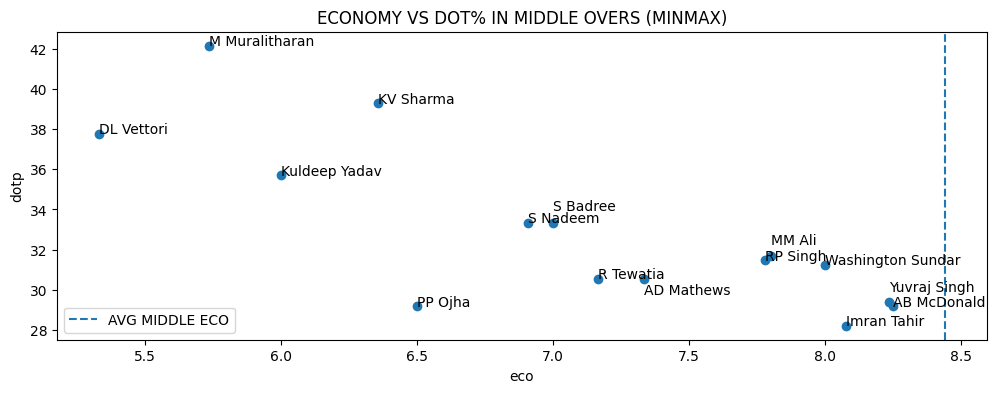

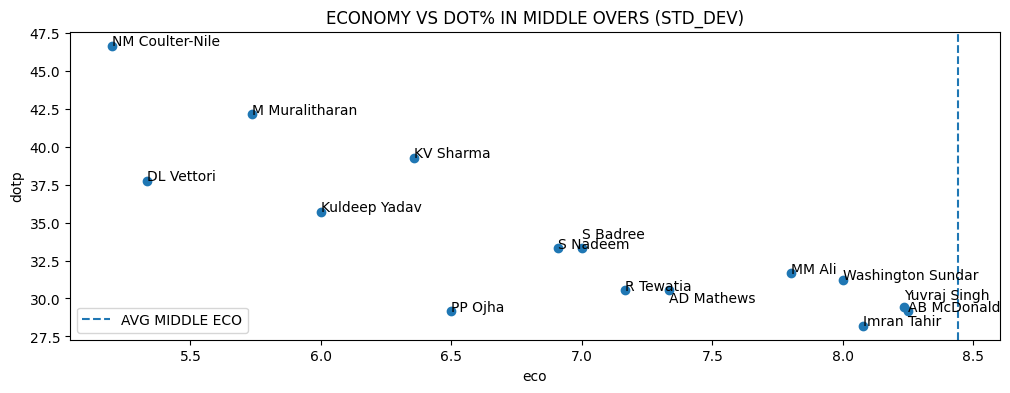

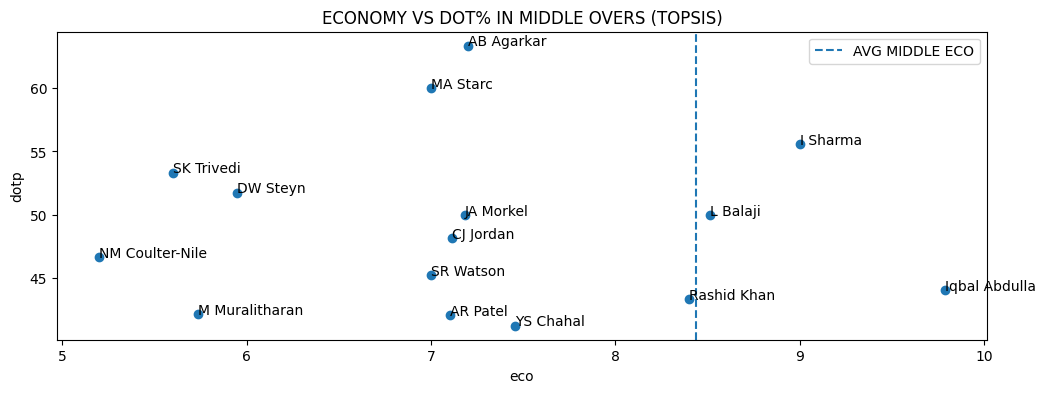

In [18]:
plt.figure(figsize=(12,4))
plt.scatter(dfmm.eco,dfmm.dotp)
for i in range(len(dfmm)):
    if dfmm.bowler[i] == 'Yuvraj Singh':
        plt.text(dfmm['eco'][i],dfmm['dotp'][i]+0.5,dfmm['bowler'][i])
    elif dfmm.bowler[i] == 'AD Mathews':
        plt.text(dfmm['eco'][i],dfmm['dotp'][i]-0.8,dfmm['bowler'][i])
    elif dfmm.bowler[i] == 'S Badree':
        plt.text(dfmm['eco'][i],dfmm['dotp'][i]+0.6,dfmm['bowler'][i])
    elif dfmm.bowler[i] == 'MM Ali':
        plt.text(dfmm['eco'][i],dfmm['dotp'][i]+0.6,dfmm['bowler'][i])
    else:
        plt.text(dfmm['eco'][i],dfmm['dotp'][i],dfmm['bowler'][i])
plt.xlabel('eco')
plt.ylabel('dotp')
plt.title('ECONOMY VS DOT% IN MIDDLE OVERS (MINMAX)')
plt.axvline(np.mean(dfm.eco),ls='--',label='AVG MIDDLE ECO')
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.scatter(dfms.eco,dfms.dotp)
for i in range(len(dfms)):
    if dfms.bowler[i] == 'Yuvraj Singh':
        plt.text(dfms['eco'][i],dfms['dotp'][i]+0.5,dfms['bowler'][i])
    elif dfms.bowler[i] == 'AD Mathews':
        plt.text(dfms['eco'][i],dfms['dotp'][i]-0.8,dfms['bowler'][i])
    elif dfms.bowler[i] == 'S Badree':
        plt.text(dfms['eco'][i],dfms['dotp'][i]+0.6,dfms['bowler'][i])
    else:
        plt.text(dfms['eco'][i],dfms['dotp'][i],dfms['bowler'][i])
plt.xlabel('eco')
plt.ylabel('dotp')
plt.title('ECONOMY VS DOT% IN MIDDLE OVERS (STD_DEV)')
plt.axvline(np.mean(dfm.eco),ls='--',label='AVG MIDDLE ECO')
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.scatter(dfmt.eco,dfmt.dotp)
for i in range(len(dfmt)):
    plt.text(dfmt['eco'][i],dfmt['dotp'][i],dfmt['bowler'][i])
plt.xlabel('eco')
plt.ylabel('dotp')
plt.title('ECONOMY VS DOT% IN MIDDLE OVERS (TOPSIS)')
plt.axvline(np.mean(dfm.eco),ls='--',label='AVG MIDDLE ECO')
plt.legend()
plt.show()

### DEATH OVERS VISUALIZATION

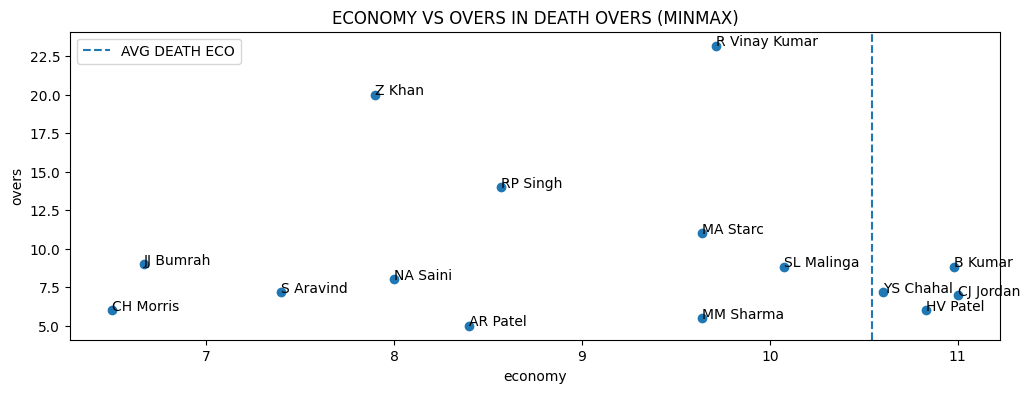

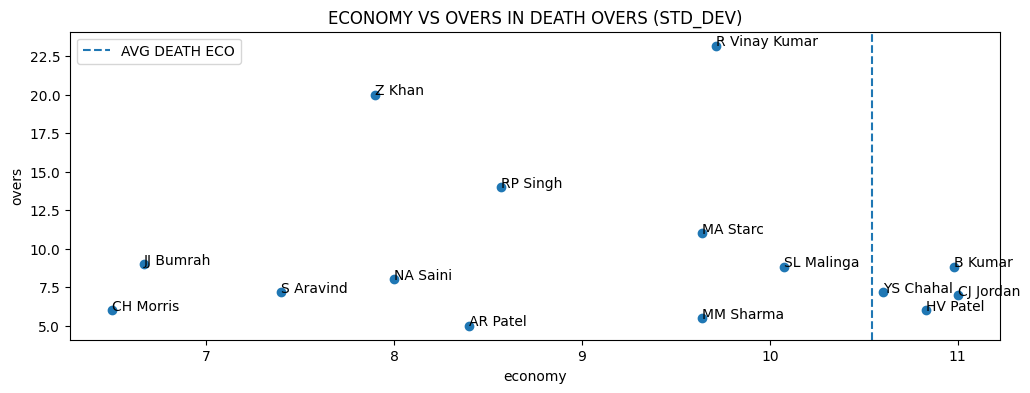

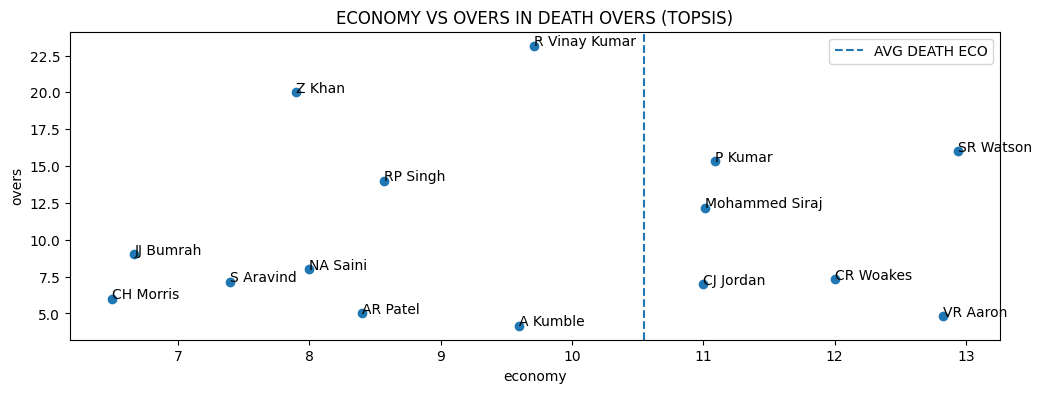

In [19]:
plt.figure(figsize=(12,4))
plt.scatter(dfdm.eco,dfdm.overs)
for i in range(len(dfdm)):
    plt.text(dfdm['eco'][i],dfdm['overs'][i],dfdm['bowler'][i])
plt.xlabel('economy')
plt.ylabel('overs')
plt.title('ECONOMY VS OVERS IN DEATH OVERS (MINMAX)')
plt.axvline(np.mean(dfd.eco),ls='--',label='AVG DEATH ECO')
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.scatter(dfds.eco,dfds.overs)
for i in range(len(dfds)):
    plt.text(dfds['eco'][i],dfds['overs'][i],dfds['bowler'][i])
plt.xlabel('economy')
plt.ylabel('overs')
plt.title('ECONOMY VS OVERS IN DEATH OVERS (STD_DEV)')
plt.axvline(np.mean(dfd.eco),ls='--',label='AVG DEATH ECO')
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.scatter(dfdt.eco,dfdt.overs)
for i in range(len(dfdt)):
    plt.text(dfdt['eco'][i],dfdt['overs'][i],dfdt['bowler'][i])
plt.xlabel('economy')
plt.ylabel('overs')
plt.title('ECONOMY VS OVERS IN DEATH OVERS (TOPSIS)')
plt.axvline(np.mean(dfd.eco),ls='--',label='AVG DEATH ECO')
plt.legend()

plt.show()

In [20]:
# plt.figure(figsize=(12,8))

# plt.subplot(221)
# plt.hist(dfd.sr)

# plt.subplot(222)
# plt.hist(dfd.avg)

# plt.subplot(223)
# plt.hist(dfd.eco)

# plt.subplot(224)
# plt.hist(dfd.dotp)
# plt.show()

In [21]:
# import seaborn as sns

In [22]:
# sns.boxplot(dfp['eco'])
# plt.show()

In [23]:
# np.percentile(dfp.eco,0),np.percentile(dfp.eco,100),np.percentile(dfm.eco,0),np.percentile(dfm.eco,100),np.percentile(dfd.eco,0),np.percentile(dfd.eco,100)

# np.percentile(dfp.eco,50),np.percentile(dfm.eco,50),np.percentile(dfd.eco,50)